In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

Загрузка библиотеки с FCA

In [2]:
import os
import sys
BASE_PATH = os.path.realpath('..')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

from lib import fca_interp as fcai

# Load Data

In [3]:
from sklearn.datasets import load_boston

boston_data = load_boston()
boston_ds = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston_ds['target'] = boston_data['target']
print(boston_ds.shape)
boston_ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
train_feats = list(boston_ds.drop('target',1).columns)
y_feat = 'target'

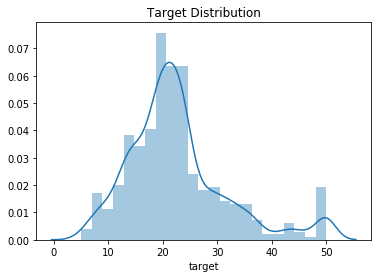

In [5]:
sns.distplot(boston_ds[y_feat])
plt.title('Target Distribution')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(boston_ds[train_feats], boston_ds[y_feat], test_size=0.1)
[x.shape for x in [X_train, X_test, y_train,  y_test]]

[(455, 13), (51, 13), (455,), (51,)]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Lattice construction on big data for supervised learning

На больших контекстах нет смысла рассчитывать все понятия. Будем аппроксимировать решётку через объединение нескольких деревьев решений (про это будет моя магистерская). Возможно такую решётку нельзя будет рассматривать, как средство для KDD (тут лучше пользоваться алгоритмом sofia, который у меня пока не имплементирова), зато её можно использовать для классификации объектов.

### Конструирование аппроксимированной решётки

Делим контекст на обучающую и тестовую выборки.

In [16]:
import json
with open('concepts30k_boston_ds.json','r') as f:
    cncpts_json = json.load(f)

In [33]:
train_objs = sorted([int(g) for g in cncpts_json['0']['extent']])

In [41]:
X_train, X_test = boston_ds.loc[train_objs, train_feats], boston_ds.drop(train_objs)[train_feats]
y_train, y_test = boston_ds.loc[train_objs, y_feat], boston_ds.drop(train_objs)[y_feat]

In [42]:
mvcntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=[])
mvcntx_test = fcai.MultiValuedContext(X_test, y_true=y_test, cat_attrs=[])

In [61]:
cncpts = []
for c_id, c_json in tqdm(cncpts_json.items()):
    c_id = int(c_id)
    c = fcai.PatternStructure(extent=c_json['extent'],
                              intent=mvcntx_train.get_intent(c_json['extent']),
                              idx=c_id)
    
    c._low_neighbs = set(c_json['low_neighbs'])
    c._up_neighbs = set(c_json['up_neighbs'])
    c._up_neighb_st = c_json['up_neighbs'][0] if c_json['up_neighbs'] != [] else None
    c._metrics = c_json['metrics']
    cncpts.append(c)

In [62]:
fm_mv = fcai.FormalManager(mvcntx_train, task_type='Regression')

In [107]:
fm_mv._concepts = cncpts
fm_mv._concepts_dict = {c.get_id():c for c in fm_mv._concepts}

In [115]:
for c in tqdm(fm_mv.get_concepts()):
    lns = [ln_id for ln_id in c._low_neighbs if fm_mv.get_concept_by_id(ln_id)._up_neighb_st==c.get_id()]
    c._low_neighbs_st = set(lns)

In [123]:
preds_test = np.array(fm_mv.predict_context(mvcntx_test)).flatten()

In [129]:
((y_test-preds_test).abs()/y_test).mean()

0.1361666124831317

   # Первые пробы Взаимной информации

In probability theory and information theory, the mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. 

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

— Page 310, Data Mining: Practical Machine Learning Tools and Techniques, 4th edition, 2016.

The mutual information between two random variables X and Y can be stated formally as follows:

$$I(X ; Y) = H(X) – H(X | Y)$$

Where I(X ; Y) is the mutual information for X and Y, H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y. The result has the units of bits.

In [155]:
for c in tqdm(fm_mv.get_concepts()):
    ys = fm_mv.get_context()._y_true[fm_mv.get_context().get_extent(c.get_intent(), verb=False)]
    c._metrics['entropy'] = ((ys-ys.mean())**2).mean()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [167]:
c_id = 45

In [168]:
chain = [c_id]
while True:
    c_id_ = chain[0]
    if c_id_ == 0:
        break
    chain = [fm_mv.get_concept_by_id(c_id_)._up_neighb_st]+chain
print(chain)

[0, 3, 34, 41, 45]


In [172]:
chain

[0, 3, 34, 41, 45]

In [169]:
upns = [c.get_id() for c in fm_mv.get_concepts() if fm_mv.get_concept_by_id(c_id).is_subconcept_of(c)]

In [170]:
upns

[45, 41, 34, 8, 7, 5, 3, 0]

In [165]:
len(upns)

5

In [168]:
chain = [c_id]
while True:
    c_id_ = chain[0]
    if c_id_ == 0:
        break
    chain = [fm_mv.get_concept_by_id(c_id_)._up_neighb_st]+chain
print(chain)

[0, 3, 34, 41, 45]


In [174]:
igs = [fm_mv.get_concept_by_id(chain[i])._metrics['entropy']-fm_mv.get_concept_by_id(chain[i+1])._metrics['entropy']
           for i in range(len(chain)-1)]
igs

[36.40561230334501, 12.27165594685927, 3.385373517193017, -0.14161422675753244]

In [175]:
sum(igs)

51.92102754063976

In [178]:
fm_mv.get_concept_by_id(0)._metrics['entropy']-fm_mv.get_concept_by_id(c_id)._metrics['entropy']

51.92102754063976

In [179]:
chain

[0, 3, 34, 41, 45]

In [180]:
fm_mv.get_concept_by_id(41)._metrics

{'mean_y_true': 23.373333333333328,
 'std_y_true': 5.687200253126322,
 'mae': 3.8300653594771226,
 'entropy': 32.21740653594772}

In [182]:
fm_mv.get_concept_by_id(45)._metrics

{'mean_y_true': 23.35098814229249,
 'std_y_true': 5.699774519685464,
 'mae': 3.8320798637691573,
 'entropy': 32.35902076270525}

In [185]:
len(fm_mv.get_concept_by_id(41).get_extent()), len(fm_mv.get_concept_by_id(45).get_extent())

(255, 253)

In [186]:
c._up_neighbs

{46, 63, 71, 73, 80, 124, 143, 150, 960, 3195, 8114}

In [188]:
fm_mv.get_concept_by_id(0)._up_neighbs

set()

In [212]:
def get_chain(fm, c_id):
    chain = [c_id]
    while True:
        c_id_ = chain[0]
        if c_id_ == 0:
            break
        chain = [fm.get_concept_by_id(c_id_)._up_neighb_st]+chain
    return chain

def get_igs(fm, chain):
    return [fm.get_concept_by_id(chain[i])._metrics['entropy']-fm.get_concept_by_id(chain[i+1])._metrics['entropy']
           for i in range(len(chain)-1)]

In [418]:
for c in tqdm(fm_mv.get_concepts()):
    if c.get_id()==0:
        c._metrics['min_ig'] = 0
        continue
    un_ids = list(c._up_neighbs)
    igs = [fm_mv.get_concept_by_id(un_id)._metrics['entropy']-c._metrics['entropy'] for un_id in un_ids]
    
    c._up_neighb_st = un_ids[np.argmin(igs)]
    c._metrics['min_ig'] = min(igs)

for c in tqdm(fm_mv.get_concepts()):
    lns = [ln_id for ln_id in c._low_neighbs if fm_mv.get_concept_by_id(ln_id)._up_neighb_st==c.get_id()]
    c._low_neighbs_st = set(lns)

In [419]:
chain_min = get_chain(fm_mv, 148)
igs_min = get_igs(fm_mv, chain_min)
chain_min, igs_min

([0, 1, 2, 4, 6, 9, 10, 11, 12, 14, 16, 33, 36, 84, 148],
 [30.88105346755149,
  6.93528080040484,
  2.68148101097011,
  1.2792654428868104,
  0.3692371637558409,
  0.624739993446191,
  0.6307919987543471,
  1.0600158569158253,
  0.008018021518381602,
  0.17189311817816133,
  12.334613571029323,
  11.480017833103643,
  2.9125902839509337,
  2.470405143097649])

In [446]:
(np.abs(s)).min()==None

False

In [492]:
fm_mv.sort_concepts()[-1]._metrics

{'mean_y_true': 0,
 'std_y_true': 0.0,
 'mae': nan,
 'entropy': nan,
 'min_ig': nan}

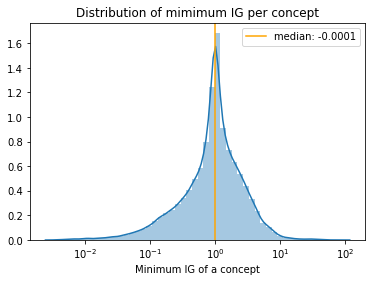

In [501]:
s = np.array([c._metrics['min_ig'] for c in fm_mv.get_concepts() if len(c.get_extent())>0])
s = np.log1p(np.abs(s))/np.log(10)*(2*(s>=0)-1)

sns.distplot(s)
xticks = [-2, -1, 0, 1, 2]
plt.xticks(xticks, ["$10^{%d}$" %x for x in xticks])
plt.xlabel('Minimum IG of a concept')
plt.title('Distribution of mimimum IG per concept')
m = np.median(s)
plt.axvline(m, label=f'median: {m:.4f}', color='orange')
plt.legend()
plt.show()

In [392]:
for c in tqdm(fm_mv.get_concepts()):
    if c.get_id()==0:
        c._metrics['min_ig'] = 0
        continue
    un_ids = list(c._up_neighbs)
    igs = [fm_mv.get_concept_by_id(un_id)._metrics['entropy']-c._metrics['entropy'] for un_id in un_ids]
    
    c._up_neighb_st = un_ids[np.argmax(igs)]
    c._metrics['min_ig'] = max(igs)

for c in tqdm(fm_mv.get_concepts()):
    lns = [ln_id for ln_id in c._low_neighbs if fm_mv.get_concept_by_id(ln_id)._up_neighb_st==c.get_id()]
    c._low_neighbs_st = set(lns)

In [393]:
chain_max = get_chain(fm_mv, 148)
igs_max = get_igs(fm_mv, chain_max)
chain_max, igs_max

([0, 1, 2, 4, 6, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 64, 84, 148],
 [30.88105346755149,
  6.93528080040484,
  2.68148101097011,
  1.2792654428868104,
  0.3692371637558409,
  0.624739993446191,
  0.6307919987543471,
  1.0600158569158253,
  0.008018021518381602,
  0.17189311817816133,
  0.6147642565999476,
  0.17674905680750896,
  -0.01601298170201204,
  0.36847314355991756,
  1.0495609924120402,
  0.7633002328905505,
  11.084394458582114,
  12.685992528933832,
  2.470405143097649])

In [394]:
def get_all_possible_chains(fm, c_id):
    if c_id==0:
        return [[0]]
    
    un_ids = fm.get_concept_by_id(c_id)._up_neighbs
    return [ch+[c_id] for un_id in un_ids for ch in get_all_possible_chains(fm, un_id)]

In [395]:
chains_all = get_all_possible_chains(fm_mv, 148)

In [409]:
chain_min

[0, 1, 2, 4, 6, 9, 10, 11, 12, 14, 16, 33, 36, 84, 148]

In [412]:
fm_mv.get_concept_by_id(16)._metrics, len(fm_mv.get_concept_by_id(16).get_extent())

({'mean_y_true': 19.987434554973824,
  'std_y_true': 6.304150131998906,
  'mae': 4.5367177434829085,
  'entropy': 39.638271428963016,
  'min_ig': 0.17189311817816133},
 382)

In [411]:
fm_mv.get_concept_by_id(33)._metrics, len(fm_mv.get_concept_by_id(33).get_extent())

({'mean_y_true': 22.58129770992366,
  'std_y_true': 5.2352907821690735,
  'mae': 3.412744012586679,
  'entropy': 27.303657857933693,
  'min_ig': 12.334613571029323},
 262)

In [402]:
chain_min

[0, 1, 2, 4, 6, 9, 10, 11, 12, 14, 16, 33, 36, 84, 148]

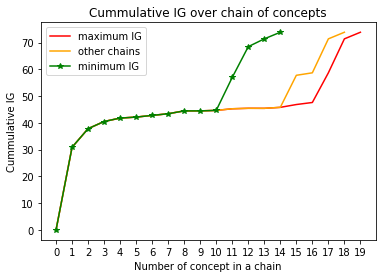

In [414]:
plt.plot(np.cumsum([0]+get_igs(fm_mv, chain_max)), label='maximum IG', color='red')
for idx, ch in enumerate([ch for ch in chains_all if ch!=chain_min and ch!=chain_max]):
    plt.plot(np.cumsum([0]+get_igs(fm_mv, ch)), label='other chains' if idx==0 else None,
             color='orange')
plt.plot(np.cumsum([0]+get_igs(fm_mv, chain_min)), '-*', label='minimum IG', color='green')
plt.title('Cummulative IG over chain of concepts')
xticks = range(max([len(ch) for ch in chains_all]))
plt.xticks(xticks, xticks)
plt.xlabel('Number of concept in a chain')
plt.ylabel('Cummulative IG')
plt.legend()
plt.show()

In [512]:
def get_change_in_intent(fm, c_id_from, c_id_to):
    int_from = fm.get_concept_by_id(c_id_from).get_intent()
    int_to = fm.get_concept_by_id(c_id_to).get_intent()
    
    change = {}
    for k in int_to.keys():
        if int_to[k]!=int_from[k]:
            change[k] = f"{int_from[k]} -> {int_to[k]}"
    return change, int_from

In [524]:
get_igs(fm_mv, [14,16])[0], get_change_in_intent(fm_mv, 14, 16)[0]

(0.17189311817816133, {'RM': '(3.561, 6.897) -> (3.561, 6.871)'})

In [528]:
fm_mv.get_concept_by_id(14)._metrics, fm_mv.get_concept_by_id(16)._metrics

({'mean_y_true': 20.0412987012987,
  'std_y_true': 6.317739853036792,
  'mae': 4.553365491651206,
  'entropy': 39.81016454714118,
  'min_ig': 0.008018021518381602},
 {'mean_y_true': 19.987434554973824,
  'std_y_true': 6.304150131998906,
  'mae': 4.5367177434829085,
  'entropy': 39.638271428963016,
  'min_ig': 0.17189311817816133})

In [518]:
get_igs(fm_mv, [16,33])[0], get_change_in_intent(fm_mv, 16, 33)[0], 

(12.334613571029323,
 {'CRIM': '(0.00632, 73.5341) -> (0.00632, 51.1358)',
  'B': '(0.32, 396.9) -> (2.6, 396.9)',
  'LSTAT': '(2.98, 37.97) -> (2.98, 16.03)'})

In [529]:
fm_mv.get_concept_by_id(16)._metrics, fm_mv.get_concept_by_id(33)._metrics

({'mean_y_true': 19.987434554973824,
  'std_y_true': 6.304150131998906,
  'mae': 4.5367177434829085,
  'entropy': 39.638271428963016,
  'min_ig': 0.17189311817816133},
 {'mean_y_true': 22.58129770992366,
  'std_y_true': 5.2352907821690735,
  'mae': 3.412744012586679,
  'entropy': 27.303657857933693,
  'min_ig': 12.334613571029323})

In [520]:
get_igs(fm_mv, [16,17])[0], get_change_in_intent(fm_mv, 16, 17)[0], 

(0.6147642565999476,
 {'RM': '(3.561, 6.871) -> (3.561, 6.842)',
  'LSTAT': '(2.98, 37.97) -> (3.26, 37.97)'})

In [530]:
fm_mv.get_concept_by_id(16)._metrics, fm_mv.get_concept_by_id(17)._metrics

({'mean_y_true': 19.987434554973824,
  'std_y_true': 6.304150131998906,
  'mae': 4.5367177434829085,
  'entropy': 39.638271428963016,
  'min_ig': 0.17189311817816133},
 {'mean_y_true': 19.85186170212766,
  'std_y_true': 6.255203422603938,
  'mae': 4.4786342802172925,
  'entropy': 39.02350717236307,
  'min_ig': 0.6147642565999476})